In [13]:
import ArticleDiscriminate
import assign_score2sql
# from API.ai_ask import get_qwen_embedding
import numpy as np
import torch
import json

In [53]:
import matplotlib.pyplot as plt
    
# 超参数设置
input_dim = 512
batch_size = 64
learning_rate = 0.0005
num_epochs = 30
negative_label=0
# 由于负例中也可能存在有用的，正例中一定是有用的，因此给negative一个松弛
positive_label=0.9
train_threshold=0.7
train_sample_bias=2
# 在考虑样本数量的基础上，放大正例的比例

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 加载数据
# positive_file = "DataSet\\with_supply_article_embed.json"
# negative_file = "DataSet\\without_supply_article_embed.json"

positive_file = "DataSet\ArticleDiscrimination\with_supply_data_list_new.json"
negative_file = "DataSet\ArticleDiscrimination\without_supply_data_list_new.json"

def load_data_from_json(positive_file, negative_file):
    "如果weight设置为None，则代表根据正负样本的比例自动确定权重"
    with open(positive_file, "r", encoding="utf-8") as f:
        positive_data = json.load(f)
    with open(negative_file, "r", encoding="utf-8") as f:
        negative_data = json.load(f)

    return (
        [item["title_des_embedding"] for item in positive_data],
        [item["title_des_embedding"] for item in negative_data],
        [item["title"] for item in positive_data],
        [item["title"] for item in negative_data],
    )

positive_embeddings, negative_embeddings, positive_contents, negative_contents = load_data_from_json(positive_file, negative_file)

# 创建数据集
dataset = ArticleDiscriminate.VectorDataset(
    positive_embeddings, negative_embeddings, 
    positive_contents, negative_contents,
    positive_label=positive_label, negative_label=negative_label
)
train_dataset, test_dataset = ArticleDiscriminate.split_dataset(dataset)

# 计算正样本权重
num_pos = len(positive_embeddings)
num_neg = len(negative_embeddings)

pos_weight = torch.tensor([num_neg / num_pos * train_sample_bias]).to(device)
# pos_weight = torch.tensor(3)

# 创建数据加载器
train_loader = ArticleDiscriminate.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = ArticleDiscriminate.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 初始化模型和优化器
model = ArticleDiscriminate.SimpleClassifier(input_dim).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # 修改损失函数（这里设置了正样本的权重，由于负样本是正样本的二倍，所以这里是正样本权重较大）
optimizer = ArticleDiscriminate.optim.Adam(model.parameters(), lr=learning_rate)

# 训练循环
best_recall = 0.0
for epoch in range(num_epochs):
    train_loss = ArticleDiscriminate.train_model(model, train_loader, criterion, optimizer, device)
    test_loss, test_recall, probas, labels, contents = ArticleDiscriminate.test_model_with_content(
        model, test_loader, criterion, device, threshold=train_threshold
    )   # 训练的时候要讲threshold设置得高一点，这样模型才有意愿好好学习，不然上来就松，后面就没法严了
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Recall @{train_threshold}: {test_recall:.4f}")
    
    # 根据召回率保存最佳模型
    if test_recall > best_recall:
        best_recall = test_recall
        torch.save(model.state_dict(), "best_model_recall.pth")
        print(f"Best model saved with Recall: {best_recall:.4f}")

Epoch [1/30]
Train Loss: 0.9891 | Test Loss: 0.9685 | Recall @0.7: 0.5189
Best model saved with Recall: 0.5189
Epoch [2/30]
Train Loss: 0.9322 | Test Loss: 0.9646 | Recall @0.7: 0.5495
Best model saved with Recall: 0.5495
Epoch [3/30]
Train Loss: 0.9032 | Test Loss: 0.9660 | Recall @0.7: 0.4982
Epoch [4/30]
Train Loss: 0.8666 | Test Loss: 0.9924 | Recall @0.7: 0.5317
Epoch [5/30]
Train Loss: 0.8335 | Test Loss: 0.9891 | Recall @0.7: 0.5039
Epoch [6/30]
Train Loss: 0.7918 | Test Loss: 1.0142 | Recall @0.7: 0.5121
Epoch [7/30]
Train Loss: 0.7492 | Test Loss: 1.0448 | Recall @0.7: 0.5452
Epoch [8/30]
Train Loss: 0.7128 | Test Loss: 1.1134 | Recall @0.7: 0.5217
Epoch [9/30]
Train Loss: 0.6715 | Test Loss: 1.1390 | Recall @0.7: 0.5773
Best model saved with Recall: 0.5773
Epoch [10/30]
Train Loss: 0.6431 | Test Loss: 1.1555 | Recall @0.7: 0.5666
Epoch [11/30]
Train Loss: 0.6148 | Test Loss: 1.2747 | Recall @0.7: 0.4947
Epoch [12/30]
Train Loss: 0.5869 | Test Loss: 1.2083 | Recall @0.7: 0.567


Optimal Threshold: 0.0000
Final Recall @0.00: 1.0000


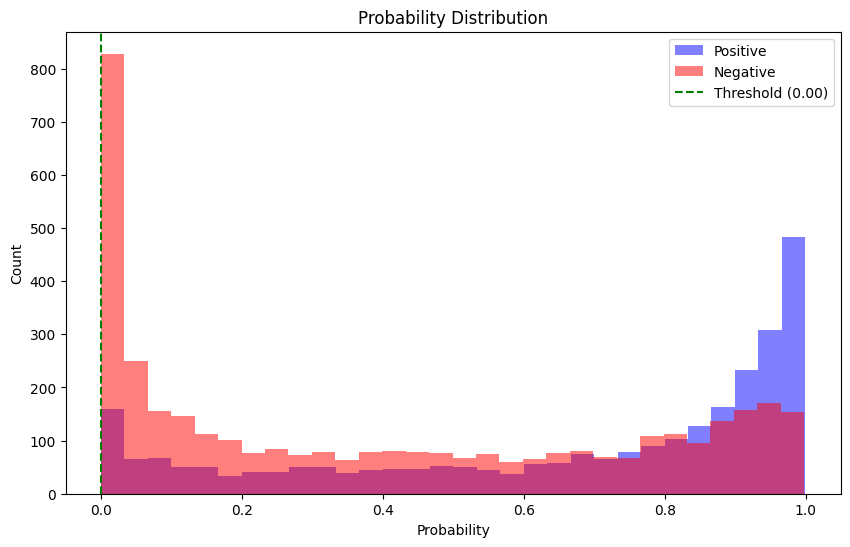

In [54]:

# 加载最佳模型
model.load_state_dict(torch.load("best_model_recall.pth"))

# 自动寻找最优阈值
final_loss, final_recall, final_probas, final_labels, final_contents = ArticleDiscriminate.test_model_with_content(
    model, test_loader, criterion, device, threshold=0.3
)
optimal_threshold = ArticleDiscriminate.find_optimal_threshold(final_probas, final_labels, target_recall=0.95)
print(f"\nOptimal Threshold: {optimal_threshold:.4f}")

# 用最优阈值进行最终评估
final_predictions = (final_probas > optimal_threshold).astype(float)
final_recall = np.sum((final_predictions == 1) & (final_labels == 1)) / np.sum(final_labels == 1)
print(f"Final Recall @{optimal_threshold:.2f}: {final_recall:.4f}")

# 可视化结果
plt.figure(figsize=(10, 6))
positive_probas = final_probas[final_labels == 1]
negative_probas = final_probas[final_labels == 0]
plt.hist(positive_probas, bins=30, alpha=0.5, label="Positive", color="blue")
plt.hist(negative_probas, bins=30, alpha=0.5, label="Negative", color="red")
plt.axvline(optimal_threshold, color="green", linestyle="--", label=f"Threshold ({optimal_threshold:.2f})")
plt.title("Probability Distribution")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

In [ ]:
with open(r"DataSet\ArticleDiscrimination\with_supply_data_list_new.json") as f:
    with_supply_data_list=json.load(f)
    
with open(r"DataSet\ArticleDiscrimination\without_supply_data_list_new.json") as f:
    without_supply_data_list=json.load(f)

# assign_score2sql.predict_text()

In [ ]:
from tqdm import tqdm

new_test_dataset=[]

for des_tensor, label, title in tqdm(test_dataset):
    title_embedding=[]
    for d in with_supply_data_list+without_supply_data_list:
        if d["title"]==title:
            title_embedding=d["title_embedding"]
            break
    if title_embedding:
        new_test_dataset.append([torch.tensor(title_embedding), des_tensor, title, round(label.item())])
    # break

100%|██████████| 6586/6586 [00:12<00:00, 515.68it/s]


In [23]:
len(new_test_dataset)

6586

In [55]:

def predict_text(embedding, threshold=0.5):
    with torch.no_grad():
        embedding_tensor = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0)  # 添加 batch 维度
        probas = torch.sigmoid(model(embedding_tensor.to(device))).cpu().numpy().item()
        predictions = (probas > threshold)
        
    # 返回一个01变量判定它是否是我们想要的
    return probas, predictions

result_list=[]
for title_tensor,des_tensor, title, label in tqdm(new_test_dataset):
    probas_title, predictions_des = assign_score2sql.predict_text(title_tensor, mode="Article")
    probas_title4des, predictions_des = assign_score2sql.predict_text(des_tensor, mode="Article")
    probas_des, predictions_des = predict_text(des_tensor)
    probas_des4title, predictions_des = predict_text(title_tensor)
    result_list.append([title, probas_title, probas_des, probas_title4des, probas_des4title, label])


  0%|          | 0/6586 [00:00<?, ?it/s]e:\BaiduSyncdisk\陈丽华老师项目\+集成电路供应链网络研究\code\SPLC_v2\assign_score2sql.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding_tensor = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0)  # 添加 batch 维度
C:\Users\zebra\AppData\Local\Temp\ipykernel_14504\2975295087.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding_tensor = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0)  # 添加 batch 维度
100%|██████████| 6586/6586 [00:14<00:00, 440.98it/s]


In [59]:
import pandas as pd

X=pd.DataFrame(result_list, columns=["item", "title", "des", "title4des", "des4title", "label"])#.to_excel("model_outputs_with_content.xlsx")

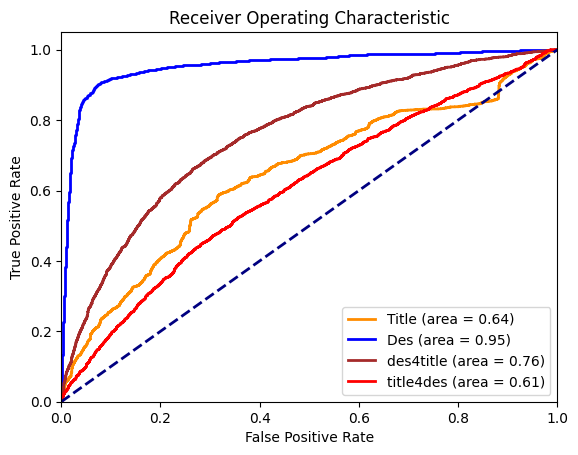

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 假设我们有两个模型的预测得分
title_scores = X['title'].values
des_scores = X['des'].values
des4title_scores = X['des4title'].values
title4des_scores = X['title4des'].values
y_true = X['label']

fpr_title, tpr_title, _ = roc_curve(y_true, title_scores)
roc_auc_title = auc(fpr_title, tpr_title)

fpr_des, tpr_des, _ = roc_curve(y_true, des_scores)
roc_auc_des = auc(fpr_des, tpr_des)

fpr_des4title, tpr_des4title, _ = roc_curve(y_true, des4title_scores)
roc_auc_des4title = auc(fpr_des4title, tpr_des4title)

fpr_title4des, tpr_title4des, _ = roc_curve(y_true, title4des_scores)
roc_auc_title4des = auc(fpr_title4des, tpr_title4des)

plt.figure()
lw = 2
plt.plot(fpr_title, tpr_title, color='darkorange', lw=lw, label='Title (area = %0.2f)' % roc_auc_title)
plt.plot(fpr_des, tpr_des, color='blue', lw=lw, label='Des (area = %0.2f)' % roc_auc_des)
plt.plot(fpr_des4title, tpr_des4title, color='brown', lw=lw, label='des4title (area = %0.2f)' % roc_auc_des4title)
plt.plot(fpr_title4des, tpr_title4des, color='red', lw=lw, label='title4des (area = %0.2f)' % roc_auc_title4des)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
'''
    结论：还是应该使用title+des
    但是这个模型确实准确率并不高

'''